In [1]:
# Downnload dataset
from datasets import Dataset, load_dataset
import torch
from transformer_lens import HookedTransformer
import numpy as np 
model_name = "EleutherAI/pythia-70m-deduped"

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

dataset_name = "NeelNanda/pile-10k"
token_amount= 40
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [2]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
from collections import Counter

layer = 4
setting = "residual"

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
elif setting == "attention":
    cache_name = f"blocks.{layer}.hook_attn_out"
    neurons = model.cfg.d_model
elif setting == "mlp_out":
    cache_name = f"blocks.{layer}.hook_mlp_out"
    neurons = model.cfg.d_model
else:
    raise NotImplementedError

# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l1_r8/_9/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l2_r4/_19/learned_dicts.pt"
autoencoder_filename = f"/mnt/ssd-cluster/longrun2408/tied_residual_l{layer}_r6/_31/learned_dicts.pt"
all_autoencoders = torch.load(autoencoder_filename)
num_dictionaries = len(all_autoencoders)
l1_alphas = []
all_monosemanticities_non_weighted = []
all_monosemanticities_weighted = []
cheap_monosemanticities = []
for auto_num in tqdm(range(num_dictionaries)):
    autoencoder, hyperparams = all_autoencoders[auto_num]
    autoencoder.to_device(device)
    l1_alphas.append(hyperparams['l1_alpha'])

    topk = 50
    search_first = 100000
    threshold = 0.1
    tokens_to_check = [187, 13, 14, 15, 253, 285, 50, 281, 247, 273, 313, 275, 27, 457, 16, 326, 352, 310, 50276, 452]

    # Now we can use the model to get the activations
    features, neurons = autoencoder.encoder.shape
    datapoints = dataset.num_rows
    batch_size = 32
    neuron_activations = torch.zeros((datapoints*token_amount, neurons))
    dictionary_activations = torch.zeros((datapoints*token_amount, features))
    all_tokens = torch.zeros((datapoints*token_amount), dtype=torch.int64)

    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            all_tokens[i*batch_size*token_amount:(i+1)*batch_size*token_amount] = batch.reshape(-1)
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
            batched_dictionary_activations = autoencoder.encode(batched_neuron_activations)
            dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()
            if(i*batch_size*token_amount > search_first):
                break
    # Better feature search for token level features
    # Find top-k activating features index for each feature
    num_data, num_features = dictionary_activations.shape
    topk_features = torch.arange(topk).repeat(num_features, 1)
    for i in range(num_features):
        # topk_features[i] = torch.topk(dictionary_activations[:search_first, i], topk)[1]
        # Convert feature index into (datapoint, seq) index
        activations = dictionary_activations[:search_first, i]
        sorted_indices = torch.argsort(activations)  # Sort activations
        non_zero_indices = sorted_indices[activations[sorted_indices] > threshold]  # Select only non-zero activations
        
        if len(non_zero_indices) < 10:  # No non-zero activations for this feature
            continue

        # # Take 'topk' evenly spaced samples from non_zero_indices
        selected_indices = torch.linspace(0, len(non_zero_indices) - 1, steps=topk).long()
        topk_features[i] = non_zero_indices[selected_indices]
        # topk_features[i] = torch.cat((non_zero_indices[selected_indices][:topk//2], non_zero_indices[selected_indices][-(topk//2):]))
    topk_features = topk_features.long()
    topk_tokens = torch.gather(all_tokens[:search_first], 0, topk_features.flatten()).reshape(topk_features.shape)


    most_common_tokens = []
    most_common_tokens_count = []
    for feature_tokens in topk_tokens.numpy():
        token_counter = Counter(feature_tokens)
        most_common_token, count = token_counter.most_common(1)[0]
        
        most_common_tokens.append(most_common_token)
        most_common_tokens_count.append(count)

    # Convert to NumPy arrays for further manipulation
    most_common_tokens = np.array(most_common_tokens)
    most_common_tokens_count = np.array(most_common_tokens_count)

    # Argsort the array
    sorted_indices = np.argsort(most_common_tokens_count)[::-1]

    most_com_tok = most_common_tokens[sorted_indices][:50]
    # Count the number of times each token appears
    c =  Counter(most_com_tok).most_common(5)
    print([(model.tokenizer.decode([x[0]]), x[1]) for x in c])
    print("Most common tokens:", most_common_tokens[sorted_indices])
    print("Count of most common tokens:", most_common_tokens_count[sorted_indices])
    print("Argsorted indices:", sorted_indices)

    cheap_monosemanticities.append((most_common_tokens_count[sorted_indices][:50] / topk).mean().item())


    # Find the first index of each token in tokens_to_check in most_common_tokens[sorted_indices]
    first_indices = []
    failed_indices = []
    for i, token in enumerate(tokens_to_check):
        try:
            first_indices.append(np.where(most_common_tokens[sorted_indices] == token)[0][0])
        except IndexError: # Token not found
            first_indices.append(0)
            failed_indices.append(i)
            print(f"Token {token} not found in most_common_tokens")
    # Use that to find the indices
    sorted_indices[first_indices]
    print(f"Sorted indices: {sorted_indices[first_indices][:10]}")
    # find the mean non_weight & weighted 
    non_weighted = []
    act_weighted = []
    for feat, tok in zip(sorted_indices[first_indices], tokens_to_check):
        feature_activation = dictionary_activations[:, feat]
        #1. Find num of nonzero elements
        nonzeros = torch.nonzero(feature_activation)[:,0]
        num_nonzeros = len(nonzeros)
        act_nonzeros_sum = torch.sum(feature_activation)
        #2. Find num of this specific token
        token_mask_nonzero = (all_tokens[nonzeros] == tok)
        num_tokens = token_mask_nonzero.sum()
        act_token_sum = torch.sum(feature_activation[nonzeros][token_mask_nonzero])
        non_weighted.append(num_tokens/num_nonzeros)
        act_weighted.append(act_token_sum/act_nonzeros_sum)
        # Set the values to zero for non_weighted & act_weighted for failed indices
    for i in failed_indices:
        non_weighted[i] = 0
        act_weighted[i] = 0
        # print(f"Non-weighted: {non_weighted:.2f}, Weighted: {act_weighted:.2f}")
    print(f"Non-weighted: {np.mean(non_weighted):.2f}, Weighted: {np.mean(act_weighted):.2f}")
    all_monosemanticities_non_weighted.append(np.mean(non_weighted))
    all_monosemanticities_weighted.append(np.mean(act_weighted))

 26%|██▌       | 79/309 [00:01<00:05, 43.10it/s]


[('\n', 46), (' relates', 1), ('4', 1), (',', 1), ('.', 1)]
Most common tokens: [7033  187  187 ...   32   35    9]
Count of most common tokens: [37 32 30 ...  1  1  1]
Argsorted indices: [2858 1572  514 ... 1444  875 1114]
Token 457 not found in most_common_tokens
Token 16 not found in most_common_tokens
Token 352 not found in most_common_tokens
Token 50276 not found in most_common_tokens
Token 452 not found in most_common_tokens
Sorted indices: [1572  470  354 1384 1832  813 2475 1806  286  912]


 11%|█         | 1/9 [00:21<02:52, 21.60s/it]

Non-weighted: 0.04, Weighted: 0.05


 26%|██▌       | 79/309 [00:01<00:05, 44.08it/s]


[('\n', 43), ('S', 1), (' without', 1), ('’', 1), (' \\[[@', 1)]
Most common tokens: [  52  187 1293 ... 1712   13   46]
Count of most common tokens: [50 50 47 ...  1  1  1]
Argsorted indices: [ 469 2328 1248 ...  874 2652  952]
Token 50 not found in most_common_tokens
Token 50276 not found in most_common_tokens
Token 452 not found in most_common_tokens
Sorted indices: [2328 2853  419  114 2120  422  469  820  985 2848]


 22%|██▏       | 2/9 [00:41<02:25, 20.73s/it]

Non-weighted: 0.11, Weighted: 0.13


 26%|██▌       | 79/309 [00:01<00:05, 43.32it/s]


[('\n', 22), (',', 3), ('.', 3), ('?', 2), ('_', 1)]
Most common tokens: [   64    13    15 ... 25825  3331   273]
Count of most common tokens: [50 50 50 ...  1  1  1]
Argsorted indices: [ 608  320 1924 ... 1244 2321 1920]
Token 50 not found in most_common_tokens
Token 452 not found in most_common_tokens
Sorted indices: [ 211  320 1883 1924 2441 1252  608 1781  663 2856]


 33%|███▎      | 3/9 [00:59<01:56, 19.41s/it]

Non-weighted: 0.66, Weighted: 0.69


 26%|██▌       | 79/309 [00:01<00:05, 40.21it/s]


[('\n', 15), ('-', 5), ('.', 4), (' of', 2), (' (', 2)]
Most common tokens: [  187   253   187 ...  1166    13 22675]
Count of most common tokens: [50 50 50 ...  1  1  1]
Argsorted indices: [ 247 1189 1465 ... 1716 1759 1690]
Sorted indices: [ 247 3006 2966 1663 1189 2881 1565 2589 2583 2359]


 44%|████▍     | 4/9 [01:15<01:30, 18.05s/it]

Non-weighted: 0.88, Weighted: 0.90


 26%|██▌       | 79/309 [00:01<00:05, 42.06it/s]


[('\n', 23), (',', 9), ('-', 4), (' the', 3), ('.', 3)]
Most common tokens: [   14   187   187 ...  8446    20 20762]
Count of most common tokens: [49 49 49 ...  1  1  1]
Argsorted indices: [1936 2574 1146 ... 2588 2581  514]
Sorted indices: [2574 1904 1936  401 1199   31 1216 2806 1029 2112]


 56%|█████▌    | 5/9 [01:29<01:05, 16.43s/it]

Non-weighted: 0.59, Weighted: 0.77


 26%|██▌       | 79/309 [00:02<00:06, 38.24it/s]


[('\n', 28), (',', 7), ('-', 4), (' and', 3), ('.', 2)]
Most common tokens: [  187   187   187 ... 30634   811 18997]
Count of most common tokens: [50 49 49 ...  1  1  1]
Argsorted indices: [  69 2004 1770 ...  759 2839 2208]
Sorted indices: [  69 2020 1878 2997 1573 3040 1327 2777  812 2345]


 67%|██████▋   | 6/9 [01:41<00:45, 15.15s/it]

Non-weighted: 0.65, Weighted: 0.81


 26%|██▌       | 79/309 [00:02<00:06, 37.22it/s]


[('\n', 28), (',', 5), ('-', 5), (' and', 4), (' (', 2)]
Most common tokens: [  346   187   187 ...  3382 20193   285]
Count of most common tokens: [50 50 49 ...  1  1  1]
Argsorted indices: [ 865 1808  245 ... 2827 1800  548]
Sorted indices: [1808 2989 1781 1412 2977 1656   14  137 2102 2485]


 78%|███████▊  | 7/9 [01:53<00:27, 13.94s/it]

Non-weighted: 0.73, Weighted: 0.83


 26%|██▌       | 79/309 [00:01<00:05, 42.82it/s]


[('\n', 21), ('.', 7), (',', 7), ('-', 5), (' and', 3)]
Most common tokens: [  187   187   187 ...   335  1694 44409]
Count of most common tokens: [49 49 48 ...  1  1  1]
Argsorted indices: [1319 1767 2268 ... 2082  825 2260]
Sorted indices: [1319  555 2388  560  228  991  482 2724 2847 1690]


 89%|████████▉ | 8/9 [02:06<00:13, 13.68s/it]

Non-weighted: 0.66, Weighted: 0.73


 26%|██▌       | 79/309 [00:01<00:05, 43.38it/s]


[(',', 35), ('\n', 7), ('Q', 2), (' the', 1), (' to', 1)]
Most common tokens: [ 187  253  187 ...  187 3090  369]
Count of most common tokens: [18 15 15 ...  2  2  2]
Argsorted indices: [1671 2230 2098 ... 2518  445  121]
Token 247 not found in most_common_tokens
Token 273 not found in most_common_tokens
Token 313 not found in most_common_tokens
Token 275 not found in most_common_tokens
Token 27 not found in most_common_tokens
Token 457 not found in most_common_tokens
Token 16 not found in most_common_tokens
Token 326 not found in most_common_tokens
Token 352 not found in most_common_tokens
Token 310 not found in most_common_tokens
Token 50276 not found in most_common_tokens
Token 452 not found in most_common_tokens
Sorted indices: [1671 1657 1756  994 2230 2187 1687  317 1671 1671]


100%|██████████| 9/9 [02:17<00:00, 15.26s/it]

Non-weighted: 0.07, Weighted: 0.08


In [24]:
most_common_tokens_count[sorted_indices][:50]

array([11,  9,  7,  6,  5,  5,  4,  3,  2,  2,  2,  2,  2,  2,  2,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

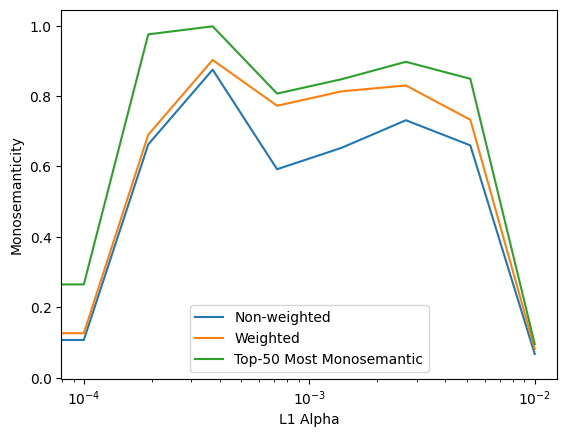

In [3]:
# Plot both all_monosemanticities_non_weighted & all_monosemanticities_weighted
import matplotlib.pyplot as plt
plt.plot(l1_alphas, all_monosemanticities_non_weighted, label="Non-weighted")
plt.plot(l1_alphas, all_monosemanticities_weighted, label="Weighted")
plt.plot(l1_alphas, cheap_monosemanticities, label="Top-50 Most Monosemantic")
plt.xlabel("L1 Alpha")
plt.ylabel("Monosemanticity")
#logscale x
plt.xscale("log")

plt.legend()
plt.show()

In [4]:
l1_alphas, cheap_monosemanticities

([0.0,
  9.999999747378752e-05,
  0.00019306977628730237,
  0.000372759357560426,
  0.0007196856895461679,
  0.0013894954463467002,
  0.0026826958637684584,
  0.005179474595934153,
  0.009999999776482582],
 [0.1812,
  0.2648,
  0.9755999999999999,
  0.9983999999999998,
  0.8071999999999998,
  0.848,
  0.8976,
  0.8491999999999998,
  0.09519999999999999])

In [13]:
model.tokenizer.decode([1147])

'It'